# Home Credit Risk

## Objetivo 
El principal objetivo de esta competencia de Data Science es desarrollar un modelo predictivo que identifique de manera eficaz a los clientes con una alta probabilidad de incumplimiento en sus obligaciones de pago de deudas. Esta herramienta de predicción debe no solo ser precisa en el corto plazo, sino también mostrar una estabilidad y fiabilidad a largo plazo.

### Requisitos (puntos a cumplir)
 - Que sea preciso y confiable
 - Estable a largo plazo
    - Sostenible que el modelo se ajuste conforme a las condiciones sin comprometer eficacia. 
        
### Requisitos
- Que no se use internet(el notebook)
- CPU y GPU <= 12 horas de tiempo de corrida
- Se puede usar información externa (modelos pre entrenados)
- Se entrega en un archivo llamado "submission.csv"

## Evaluación

1. Innovación - 40%: Analiza la estabilidad crediticia a lo largo del tiempo, centrándose específicamente en la métrica de evaluación de la competencia más allá de la simple selección de características. p.ej. Gini medio elevado, rendimiento no decreciente en el tiempo, pequeñas oscilaciones…
2. Calidad - 20%: todas las tablas, figuras y/o muestras de código son de alta calidad (por ejemplo, densas en información, fáciles de entender e informativas).
3. Claridad - 20%: la composición general es articulada, concisa, precisa y fácil de entender.
4. Generalización (20%): la implementación de la estabilidad como métrica se puede aplicar a conjuntos de datos que no son de competencia.

## Entendimiento del negocio
Para entender esta competencia hay que entender que es "Home Credit" y que es lo que nos pide el reto:

### Reto
El reto es generar el riesgo de posibles clientes, a manera de que los proveedores de finanzas puedan aceptar más préstamos, sobre todo a gente de edad temprana, gente que prefiere usar cash, lo que no les ha permitido generar un historial crediticio, nuestro deber es determinar de manera precisa si estos clientes pueden pagar o no.
Es importante tener en cuenta que el comportamiento de los clientes cambia constantemente por lo que es importante que se puede actualizar, haciendo que el modelo sea estable, con el tiempo.


### Empresa
Home Credit es una institución financiera internacional que se especializa en la concesión de préstamos no garantizados a consumidores que típicamente tienen un acceso limitado a los servicios bancarios tradicionales. Fundada en 1997 en la República Checa, la compañía ha expandido sus operaciones a través de Europa, Asia y los Estados Unidos, ofreciendo una gama de productos financieros que incluyen préstamos al consumo, tarjetas de crédito y financiamiento en puntos de venta.
La misión principal de Home Credit es proporcionar préstamos accesibles y sencillos a clientes que no tienen un historial crediticio extenso o que están excluidos del sistema bancario tradicional. Esto permite a más personas acceder a financiamiento para bienes de consumo y otros gastos personales, fomentando la inclusión financiera.


# Procesamiento y entendimiento de datos

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

dataPath = "home-credit-credit-risk-model-stability/"

In [2]:
def set_table_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:
        if col[-1] in ("P", "A"):
            df[col] = df[col].astype(float)
    return df

def convert_strings(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].astype('category')
            current_categories = df[col].cat.categories
            new_categories = current_categories.to_list() + ["Unknown"]
            new_dtype = pd.CategoricalDtype(categories=new_categories, ordered=True)
            df[col] = df[col].astype(new_dtype)
    return df


In [3]:
# Load the data
train_basetable = pd.read_csv(dataPath + "csv_files/train/train_base.csv")
train_static = pd.concat(
    [
        pd.read_csv(dataPath + "csv_files/train/train_static_0_0.csv").pipe(set_table_dtypes),
        pd.read_csv(dataPath + "csv_files/train/train_static_0_1.csv").pipe(set_table_dtypes),
    ],
    axis=0
)
train_static_cb = pd.read_csv(dataPath + "csv_files/train/train_static_cb_0.csv").pipe(set_table_dtypes)
train_person_1 = pd.read_csv(dataPath + "csv_files/train/train_person_1.csv").pipe(set_table_dtypes)
train_credit_bureau_b_2 = pd.read_csv(dataPath + "csv_files/train/train_credit_bureau_b_2.csv").pipe(set_table_dtypes)


/var/folders/nz/ntbk00f557jfbvm0fp_h8yyh0000gn/T/ipykernel_85554/3266075270.py:5: DtypeWarning: Columns (20,45,46,53,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(dataPath + "csv_files/train/train_static_0_0.csv").pipe(set_table_dtypes),
/var/folders/nz/ntbk00f557jfbvm0fp_h8yyh0000gn/T/ipykernel_85554/3266075270.py:6: DtypeWarning: Columns (20,45,46,56,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(dataPath + "csv_files/train/train_static_0_1.csv").pipe(set_table_dtypes),
/var/folders/nz/ntbk00f557jfbvm0fp_h8yyh0000gn/T/ipykernel_85554/3266075270.py:10: DtypeWarning: Columns (1,2,3,4,7,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  train_static_cb = pd.read_csv(dataPath + "csv_files/train/train_static_cb_0.csv").pipe(set_table_dtypes)
/var/folders/nz/ntbk00f557jfbvm0fp_h8yyh0000gn/T/ipykernel_85554/3266075270.py:11: DtypeWarn

In [4]:
test_basetable = pd.read_csv(dataPath + "csv_files/test/test_base.csv")
test_static = pd.concat(
    [
        pd.read_csv(dataPath + "csv_files/test/test_static_0_0.csv").pipe(set_table_dtypes),
        pd.read_csv(dataPath + "csv_files/test/test_static_0_1.csv").pipe(set_table_dtypes),
        pd.read_csv(dataPath + "csv_files/test/test_static_0_2.csv").pipe(set_table_dtypes),
    ],
    axis=0
)
test_static_cb = pd.read_csv(dataPath + "csv_files/test/test_static_cb_0.csv").pipe(set_table_dtypes)
test_person_1 = pd.read_csv(dataPath + "csv_files/test/test_person_1.csv").pipe(set_table_dtypes)
test_credit_bureau_b_2 = pd.read_csv(dataPath + "csv_files/test/test_credit_bureau_b_2.csv").pipe(set_table_dtypes)


## Feature engineering

In [5]:
train_person_1_feats_1 = train_person_1.groupby("case_id").agg(
    mainoccupationinc_384A_max=pd.NamedAgg(column="mainoccupationinc_384A", aggfunc="max"),
    mainoccupationinc_384A_any_selfemployed=pd.NamedAgg(column="incometype_1044T", aggfunc=lambda x: (x == "SELFEMPLOYED").max())
).reset_index()

train_person_1_feats_2 = train_person_1.loc[train_person_1["num_group1"] == 0, ["case_id", "housetype_905L"]]
train_person_1_feats_2 = train_person_1_feats_2.rename(columns={"housetype_905L": "person_housetype"})

train_credit_bureau_b_2_feats = train_credit_bureau_b_2.groupby("case_id").agg(
    pmts_pmtsoverdue_635A_max=pd.NamedAgg(column="pmts_pmtsoverdue_635A", aggfunc="max"),
    pmts_dpdvalue_108P_over31=pd.NamedAgg(column="pmts_dpdvalue_108P", aggfunc=lambda x: (x > 31).max())
).reset_index()

selected_static_cols = [col for col in train_static.columns if col[-1] in ("A", "M")]
print(selected_static_cols)

selected_static_cb_cols = [col for col in train_static_cb.columns if col[-1] in ("A", "M")]
print(selected_static_cb_cols)

# Join all tables together
data = train_basetable.merge(
    train_static[["case_id"] + selected_static_cols], how="left", on="case_id"
).merge(
    train_static_cb[["case_id"] + selected_static_cb_cols], how="left", on="case_id"
).merge(
    train_person_1_feats_1, how="left", on="case_id"
).merge(
    train_person_1_feats_2, how="left", on="case_id"
).merge(
    train_credit_bureau_b_2_feats, how="left", on="case_id"
)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

In [6]:
test_person_1_feats_1 = test_person_1.groupby("case_id").agg(
    mainoccupationinc_384A_max=pd.NamedAgg(column="mainoccupationinc_384A", aggfunc="max"),
    mainoccupationinc_384A_any_selfemployed=pd.NamedAgg(column="incometype_1044T", aggfunc=lambda x: (x == "SELFEMPLOYED").max())
).reset_index()

test_person_1_feats_2 = test_person_1.loc[test_person_1["num_group1"] == 0, ["case_id", "housetype_905L"]]
test_person_1_feats_2 = test_person_1_feats_2.rename(columns={"housetype_905L": "person_housetype"})

test_credit_bureau_b_2_feats = test_credit_bureau_b_2.groupby("case_id").agg(
    pmts_pmtsoverdue_635A_max=pd.NamedAgg(column="pmts_pmtsoverdue_635A", aggfunc="max"),
    pmts_dpdvalue_108P_over31=pd.NamedAgg(column="pmts_dpdvalue_108P", aggfunc=lambda x: (x > 31).max())
).reset_index()

data_submission = test_basetable.merge(
    test_static[["case_id"] + selected_static_cols], how="left", on="case_id"
).merge(
    test_static_cb[["case_id"] + selected_static_cb_cols], how="left", on="case_id"
).merge(
    test_person_1_feats_1, how="left", on="case_id"
).merge(
    test_person_1_feats_2, how="left", on="case_id"
).merge(
    test_credit_bureau_b_2_feats, how="left", on="case_id"
)

In [7]:
case_ids = data["case_id"].sample(frac=1, random_state=1)
case_ids_train, case_ids_test = train_test_split(case_ids, train_size=0.6, random_state=1)
case_ids_valid, case_ids_test = train_test_split(case_ids_test, train_size=0.5, random_state=1)

cols_pred = [col for col in data.columns if col[-1].isupper() and col[:-1].islower()]
print(cols_pred)

# Split data into training, validation, and test sets
train_data = data[data["case_id"].isin(case_ids_train)]
valid_data = data[data["case_id"].isin(case_ids_valid)]
test_data = data[data["case_id"].isin(case_ids_test)]

X_train, y_train = train_data[cols_pred], train_data["target"]
X_valid, y_valid = valid_data[cols_pred], valid_data["target"]
X_test, y_test = test_data[cols_pred], test_data["target"]

for df in [X_train, X_valid, X_test]:
    df = convert_strings(df)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

/var/folders/nz/ntbk00f557jfbvm0fp_h8yyh0000gn/T/ipykernel_85554/3701655525.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype('category')
/var/folders/nz/ntbk00f557jfbvm0fp_h8yyh0000gn/T/ipykernel_85554/3701655525.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(new_dtype)
/var/folders/nz/ntbk00f557jfbvm0fp_h8yyh0000gn/T/ipykernel_85554/3701655525.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [8]:
print(f"Train: {X_train.shape}")
print(f"Valid: {X_valid.shape}")
print(f"Test: {X_test.shape}")

Train: (915995, 48)
Valid: (305332, 48)
Test: (305332, 48)


## Training LightGBM

In [9]:
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_valid = lgb.Dataset(X_valid, label=y_valid, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 3,
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "n_estimators": 1000,
    "verbose": -1,
}
evals={}
gbm = lgb.train(
    params,
    lgb_train,
    valid_sets=lgb_valid,
    callbacks=[lgb.log_evaluation(50), lgb.early_stopping(10), lgb.record_evaluation(evals)]
)

/opt/homebrew/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	valid_0's auc: 0.699919
[100]	valid_0's auc: 0.717512
[150]	valid_0's auc: 0.7247
[200]	valid_0's auc: 0.728744
[250]	valid_0's auc: 0.731757
[300]	valid_0's auc: 0.734638
[350]	valid_0's auc: 0.736952
[400]	valid_0's auc: 0.738423
[450]	valid_0's auc: 0.739968
[500]	valid_0's auc: 0.74133
[550]	valid_0's auc: 0.742478
[600]	valid_0's auc: 0.743322
[650]	valid_0's auc: 0.744115
[700]	valid_0's auc: 0.744701
[750]	valid_0's auc: 0.745422
Early stopping, best iteration is:
[765]	valid_0's auc: 0.745759


<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='auc'>

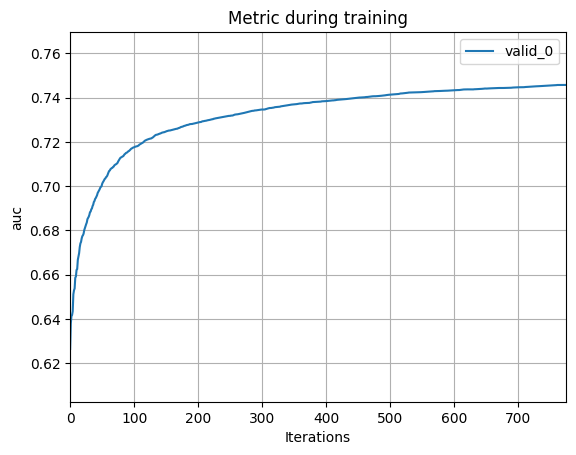

In [10]:
lgb.plot_metric(evals)

In [11]:
for base, X in [(train_data, X_train), (valid_data, X_valid), (test_data, X_test)]:
    y_pred = gbm.predict(X, num_iteration=gbm.best_iteration)
    base["score"] = y_pred

print(f'The AUC score on the train set is: {roc_auc_score(train_data["target"], train_data["score"])}')
print(f'The AUC score on the valid set is: {roc_auc_score(valid_data["target"], valid_data["score"])}')
print(f'The AUC score on the test set is: {roc_auc_score(test_data["target"], test_data["score"])}')

/var/folders/nz/ntbk00f557jfbvm0fp_h8yyh0000gn/T/ipykernel_85554/581506551.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base["score"] = y_pred
/var/folders/nz/ntbk00f557jfbvm0fp_h8yyh0000gn/T/ipykernel_85554/581506551.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base["score"] = y_pred
/var/folders/nz/ntbk00f557jfbvm0fp_h8yyh0000gn/T/ipykernel_85554/581506551.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

The AUC score on the train set is: 0.7647558361580861
The AUC score on the valid set is: 0.7457594178711751
The AUC score on the test set is: 0.7541589104304902


In [12]:
def gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5):
    gini_in_time = base.loc[:, ["WEEK_NUM", "target", "score"]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", "score"]]\
        .apply(lambda x: 2*roc_auc_score(x["target"], x["score"])-1).tolist()

    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a*x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.mean(gini_in_time)
    return avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

stability_score_train = gini_stability(train_data)
stability_score_valid = gini_stability(valid_data)
stability_score_test = gini_stability(test_data)

print(f'The stability score on the train set is: {stability_score_train}')
print(f'The stability score on the valid set is: {stability_score_valid}')
print(f'The stability score on the test set is: {stability_score_test}')

The stability score on the train set is: 0.5041180820280722
The stability score on the valid set is: 0.4477715566725867
The stability score on the test set is: 0.46531836563301116


## Submission

In [13]:
X_submission = data_submission[cols_pred]
X_submission = convert_strings(X_submission)
categorical_cols = X_train.select_dtypes(include=['category']).columns

for col in categorical_cols:
    train_categories = set(X_train[col].cat.categories)
    submission_categories = set(X_submission[col].cat.categories)
    new_categories = submission_categories - train_categories
    X_submission.loc[X_submission[col].isin(new_categories), col] = "Unknown"
    new_dtype = pd.CategoricalDtype(categories=train_categories, ordered=True)
    X_train[col] = X_train[col].astype(new_dtype)
    X_submission[col] = X_submission[col].astype(new_dtype)

y_submission_pred = gbm.predict(X_submission, num_iteration=gbm.best_iteration)

/var/folders/nz/ntbk00f557jfbvm0fp_h8yyh0000gn/T/ipykernel_85554/3701655525.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype('category')
/var/folders/nz/ntbk00f557jfbvm0fp_h8yyh0000gn/T/ipykernel_85554/3701655525.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(new_dtype)
/var/folders/nz/ntbk00f557jfbvm0fp_h8yyh0000gn/T/ipykernel_85554/3701655525.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [14]:
submission = pd.DataFrame({
    "case_id": data_submission["case_id"].to_numpy(),
    "score": y_submission_pred
}).set_index('case_id')
submission.to_csv("./submission.csv")